  **1.- M87**

---

Se obtienen las imágenes de M81 de *Hubble Legacy Archive* seleccionadas con los siguientes criterios:

| Objeto | Programa | Nombre PI | Detector |    Filtros     |
|:------:|:--------:|:---------:|:--------:|:--------------:|
|  M87   |   9401   |    Cote   | ACS/WFC  | F475W - F850LP |

Luego guardamos los datos en un archivo, extrayendo imágenes de ciencia y las imágenes de pesos.

In [1]:
from astropy.io import fits

hdulist1 = fits.open('hst_9401_02_acs_wfc_f475w_drz.fits')
hdulist1.info()
fits.writeto("sci_{}".format("f475w.fits"), hdulist1[1].data, hdulist1[1].header, clobber=True)
fits.writeto("invar_{}".format("f475w.fits"), hdulist1[2].data, hdulist1[2].header, clobber=True)
hdulist1.close()
hdulist2 = fits.open('hst_9401_02_acs_wfc_f850lp_drz.fits')
hdulist2.info()
fits.writeto("sci_{}".format("f850lp.fits"), hdulist2[1].data, hdulist2[1].header, clobber=True)
fits.writeto("invar_{}".format("f850lp.fits"), hdulist2[2].data, hdulist2[2].header, clobber=True)
hdulist2.close()

Filename: hst_9401_02_acs_wfc_f475w_drz.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     788   ()              
1    SCI         ImageHDU        85   (4238, 4213)   float32   
2    WHT         ImageHDU        47   (4238, 4213)   float32   
3    CTX         ImageHDU        40   (4238, 4213)   int32   
4    HDRTAB      BinTableHDU    631   4R x 311C    [9A, 3A, J, D, D, D, D, D, D, D, D, D, D, D, D, D, J, 3A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, J, 8A, 23A, D, D, D, D, J, J, J, 8A, J, 23A, 9A, 19A, J, 4A, J, J, J, J, J, J, 23A, D, D, D, D, J, J, 3A, 23A, 4A, 7A, J, D, D, D, 23A, 1A, J, D, D, D, 13A, 3A, 4A, 4A, 12A, 12A, 23A, 8A, 23A, 10A, 10A, D, D, 3A, 3A, 23A, 4A, 8A, 7A, 23A, D, J, D, 6A, 9A, 8A, D, D, J, 4A, 18A, 3A, J, 5A, 7A, 3A, D, 13A, 8A, 4A, 3A, J, J, J, J, J, J, J, D, D, D, D, D, D, 23A, 1A, D, 23A, D, D, D, 3A, 23A, J, 1A, 3A, 1A, D, 3A, 6A, J, D, D, D, D, D, D, D, D, D, D, 23A, D, D, D, D, 3A, D, 

Utilizamos el comando para ver el input que se necesita para correr sextractor

In [2]:
!sextractor -h


> SYNTAX: sextractor <image> [<image2>][-c <configuration_file>][-<keyword> <value>]
> to dump a default configuration file:          sextractor -d 
> to dump a default extended configuration file: sextractor -dd 
> to dump a full list of measurement parameters: sextractor -dp 




Para detectar la fuentes se determinan ciertos los parámetros en el archivo *default.sex*. Para darle pesos a las cuentas de los pixeles configuramos *WEIGHT_TYPE* en *MAP_WEIGH* y le damos la imágenes de los inverzos de las varianzas *invar_filtro.fits* a *WEIGHT_IMAGE*. De la literatura (fuente indicada más abajo) se obtiene que el *GAIN* y el *SEEING_FWHM* con valores de 1 y 0.12 respectivamente. *PIXEL_SCALE* se configura en 0 para que el programa lo lea directamente del header. Con DS9 se observan las imágenes y se determina que hay fuentes con 6 pixeles, por lo que se configura *DETECT_MINAREA* en 3 y *PHOT_APERTURES* en 7. Finalmente *MAG_ZEROPOINT* se determina en 25.

Para el archivo de salida, se obtienen las cantidades que se descomentan en el archivo *default.param*. Dichas cantidades son *MAG_APER*, *MAGERR_APER*, *ALPHA_J2000* y *DELTA_J2000*.

Corremos sextractor para las dos imágenes y se imprime en pantalla el resultado

In [3]:
salida1 = !sextractor sci_f475w.fits -c default.sex
print('F475W\n', salida1.n[-152:], '\n')

F475W
  Objects: detected 6412     / sextracted 4260            

> Closing files
> 
> All done (in 11.8 s: 357.9 lines/s , 361.9 detections/s) 



In [4]:
salida2 = !sextractor sci_f850lp.fits -c default.sex
print('F850LP\n', salida2.n[-152:], '\n')

F850LP
  Objects: detected 9146     / sextracted 5642            

> Closing files
> 
> All done (in 16.5 s: 255.1 lines/s , 341.6 detections/s) 



Se realiza la union de las fuentes coincidentes en los dos catálogos y se hace la calibración fotométrica:

$MAG_{corr} = MAG + A_{λ} + Aper_{corr}$

$F475W_{corr} = F475W + 0.075 + Aper_{corr}$

$F850LP_{corr} = F850LP + 0.029 + Aper_{corr}$

In [2]:
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np

catalogos = []
coordenadas = []

f475w = ascii.read('f475w.cat')
catalogos.append(f475w)
coordenadas.append(SkyCoord(ra=f475w['ALPHA_J2000'],dec=f475w['DELTA_J2000'],unit='deg'))

f850lp = ascii.read('f850lp.cat')
catalogos.append(f850lp)
coordenadas.append(SkyCoord(ra=f850lp['ALPHA_J2000'],dec=f850lp['DELTA_J2000'],unit='deg'))

idx, sep2d, dist3d = SkyCoord.match_to_catalog_sky(coordenadas[0],coordenadas[1])
union = list(zip(range(0, len(idx)), idx, sep2d))

par1, par2, par3 = zip(*union)
catalogos[0] = catalogos[0][list(par1)]
catalogos[1] = catalogos[1][list(par2)]

Lf475w = list(map(lambda x: x+0.075+0.44, catalogos[0]['MAG_APER']))
Lf850lp = list(map(lambda x: x+0.029+0.81, catalogos[1]['MAG_APER']))

Se realiza un histograma de color obtenido con las magnitudes de la fotometría

Populating the interactive namespace from numpy and matplotlib


(array([   4.,    4.,    3.,    5.,    3.,    3.,    7.,    4.,    2.,
           5.,    8.,    5.,    6.,    9.,    7.,   11.,    9.,   14.,
          19.,   17.,   24.,   29.,   54.,   85.,  130.,  145.,  135.,
         131.,  115.,  118.,  127.,  125.,  121.,  180.,  189.,  194.,
         225.,  203.,  155.,  128.,   99.,   78.,   80.,   79.,   71.,
          72.,   61.,   52.,   53.,   48.,   46.,   29.,   50.,   36.,
          26.,   23.,   32.,   34.,   22.,   27.,   13.,   16.,   15.,
          19.,   15.,   15.,   12.,   12.,   12.,   14.,   13.,   12.,
          10.,   12.,    9.,   10.,   12.,    7.,    8.,    1.,    8.,
           6.,    8.,   12.,    4.,   10.,    7.,    8.,    8.,   13.,
           6.,    4.,    9.,    6.,    4.,    4.,    2.,    4.,    2.,    6.]),
 array([-1.9573  , -1.907742, -1.858184, -1.808626, -1.759068, -1.70951 ,
        -1.659952, -1.610394, -1.560836, -1.511278, -1.46172 , -1.412162,
        -1.362604, -1.313046, -1.263488, -1.21393 , -1.164372,

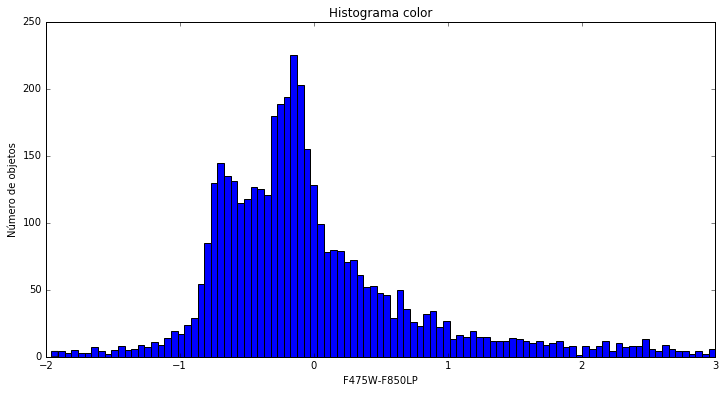

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%pylab inline

dif = []
for i in range(len(Lf475w)):
    if Lf475w[i] - Lf850lp[i] > -2 and Lf475w[i] - Lf850lp[i] < 3:
        dif.append(Lf475w[i] - Lf850lp[i])

plt.subplots(figsize=(12,6))
plt.title("Histograma color")
plt.xlabel("F475W-F850LP")
plt.ylabel("Número de objetos")
plt.hist(dif, bins = 100)

Del histograma vemos que hay dos máximos, que corresponden probablemente a dos periodos de formación de cúmulos, uno mas antiguo que el otro debido a que uno es más azul.

Para determinar la distancia hacemos el histograma de cada uno de los filtros

(array([   4.,    4.,    6.,   10.,    4.,    8.,   11.,   11.,   10.,
           7.,   14.,   16.,   12.,   21.,   17.,   19.,   13.,   10.,
          11.,   16.,   14.,   20.,   18.,   22.,   19.,   21.,   25.,
          15.,   18.,   21.,   31.,   29.,   35.,   31.,   28.,   41.,
          27.,   30.,   38.,   32.,   47.,   33.,   40.,   35.,   31.,
          45.,   38.,   38.,   42.,   41.,   38.,   42.,   47.,   37.,
          32.,   37.,   37.,   33.,   34.,   60.,   44.,   45.,   58.,
          57.,   69.,   66.,   86.,   96.,  110.,   97.,  132.,  114.,
         150.,  139.,  132.,  137.,  120.,  123.,  125.,  112.,   88.,
          88.,   96.,   68.,   62.,   57.,   48.,   31.,   25.,   16.,
          20.,   15.,   18.,   13.,    7.,    4.,    5.,    5.,    4.,    2.]),
 array([ 21.0176  ,  21.076733,  21.135866,  21.194999,  21.254132,
         21.313265,  21.372398,  21.431531,  21.490664,  21.549797,
         21.60893 ,  21.668063,  21.727196,  21.786329,  21.845462,
      

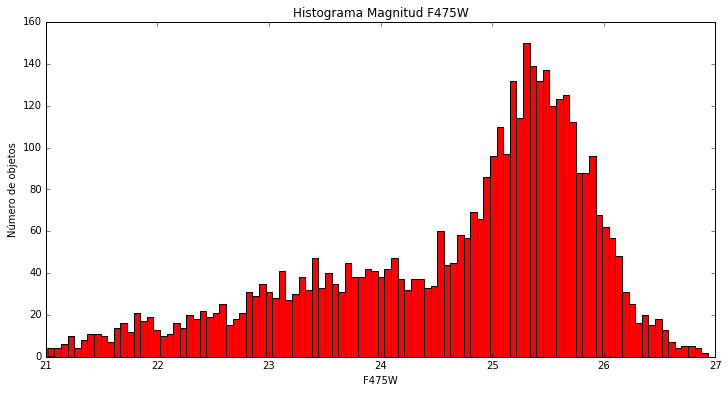

In [49]:
dif2 = []
for i in range(len(Lf475w)):
    if Lf475w[i] > 21 and Lf475w[i] < 27:
        dif2.append(Lf475w[i])

plt.subplots(figsize=(12,6))
plt.title("Histograma Magnitud F475W")
plt.xlabel("F475W")
plt.ylabel("Número de objetos")
plt.hist(dif2, bins = 100, facecolor='red')

(array([   7.,    3.,    3.,    2.,    0.,    3.,    7.,    6.,    6.,
           9.,    7.,   10.,    8.,   11.,   11.,   18.,   19.,   23.,
          23.,   12.,   14.,   18.,   23.,   23.,   16.,   24.,   28.,
          29.,   23.,   14.,   24.,   23.,   17.,   22.,   28.,   36.,
          42.,   40.,   49.,   39.,   33.,   22.,   51.,   38.,   52.,
          62.,   37.,   45.,   59.,   62.,   45.,   50.,   63.,   55.,
          57.,   60.,   31.,   30.,   53.,   46.,   57.,   74.,   73.,
         103.,   98.,  127.,   78.,   95.,  103.,  148.,  112.,  111.,
          97.,  124.,  100.,  122.,  115.,   73.,   83.,   72.,   76.,
          57.,   55.,   52.,   62.,   50.,   38.,   31.,   46.,   27.,
          21.,   17.,    7.,    7.,    6.,    5.,    4.,    2.,    8.,    2.]),
 array([ 21.016   ,  21.075737,  21.135474,  21.195211,  21.254948,
         21.314685,  21.374422,  21.434159,  21.493896,  21.553633,
         21.61337 ,  21.673107,  21.732844,  21.792581,  21.852318,
      

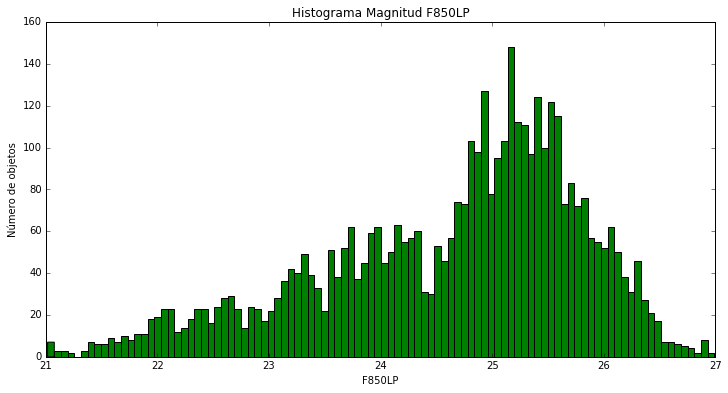

In [50]:
dif3 = []
for i in range(len(Lf850lp)):
    if Lf850lp[i] > 21 and Lf850lp[i] < 27:
        dif3.append(Lf850lp[i])

plt.subplots(figsize=(12,6))
plt.title("Histograma Magnitud F850LP")
plt.xlabel("F850LP")
plt.ylabel("Número de objetos")
plt.hist(dif3, bins = 100, facecolor='green')

El máximo se ve en magnitud 25,3. Como el máximo en magnitud absoluta se espera que esté en magnitud $M_V = -7.4$, usamos el módulo de distancia para calcular la distancia física a M87.

$d = 10^{(\frac{m-M+5}{5})}$

In [2]:
d = 10**((25.1+7.4+5)/5)

print("La distancia a M87 es:", d/(10**6), "Mpc")

La distancia a M87 es: 31.622776601683793 Mpc


Se descarga las imágenes de rayos X de Chandra de M87 para tiempos mayores a 100 ks

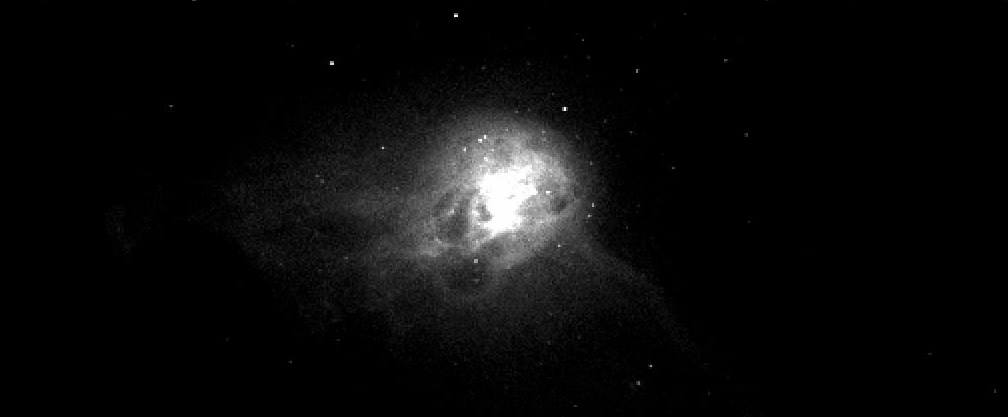

In [25]:
from IPython.display import Image

Image(filename="m87.jpg")

Usamos sextractor en la imagen de Chandra

In [28]:
salida1 = !sextractor acisf05826N003_full_img2.fits -c default.sex
print('Xray\n', salida1.n[-152:], '\n')

Xray
  Objects: detected 43       / sextracted 10              

> Closing files
> 
> All done (in 0.1 s: 4924.8 lines/s , 157.8 detections/s) 



In [46]:
Xray = ascii.read('xray.cat')
Xray

MAG_APER,MAGERR_APER,ALPHA_J2000,DELTA_J2000
mag,mag,deg,deg
float64,float64,float64,float64
15.9859,0.0214,187.6922752,12.4189314
15.5056,0.0137,187.7428993,12.3934599
13.6761,0.0025,187.704616,12.3853526
16.5178,0.0348,187.7454279,12.4238211
17.6832,0.1022,187.6362888,12.365903
18.1761,0.1608,187.726137,12.5068871
17.9893,0.1353,187.8046331,12.4791289
17.6952,0.1032,187.6135042,12.4179924


La emisión en rayos X en una galaxia se puede deber a muchos proceso violentos como supernovas, jets de emisión o discos de acreción de agujeros negros y explosiones de novas.
Las supernovas no pueden mantener la tasa de emisión de rayos X observada, mientras que en cúmulos globulares, que son altamente densos, puede ser común que estrellas pequeñas como estrellas de neutrones o enanas blancas acreten material de un vecino cercano comenzando reacciones que producen novas, emitiendo en rayos X.

Fuentes:
> *http://cda.harvard.edu/chaser/dispatchOcat.do*